# Postprocessing Demo
This notebook explains step by step how raw depth maps are refined and cleaned up.

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import scipy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from mit_semseg.utils import colorEncode
from megadepth.postprocessing.image_processing import erode_and_remove, filter_unstable_depths
from megadepth.postprocessing.semantic_filtering import get_mask, apply_semantic_filtering
from megadepth.postprocessing.semantic_segmentation import get_segmentation_map, get_segmentation_model
from megadepth.utils.io import load_depth_map

In [3]:
colors = scipy.io.loadmat("color150.mat")["colors"]

def plot_images(images: list, titles: list) -> None:
    fig = plt.figure(figsize=(15, 15))

    for i in range(len(images)):
        fig.add_subplot(1, len(images), i+1)
        plt.axis("off")
        plt.imshow(images[i])
        plt.title(titles[i])


Feel free to change the variables in the following cell to try out other images and depth maps:

In [4]:
dense_model_dir = os.path.join("..", "data", "south-building", "dense", "colmap")
image_fn = "P1180218.JPG"

### Image Processing I
As a first step, we filter unstable depth values by. A depth value is thereby removed if it deviates too much from the median depth value of its local neighborhood.

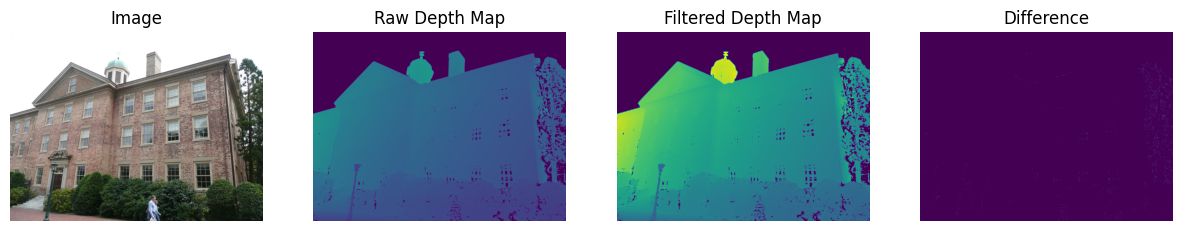

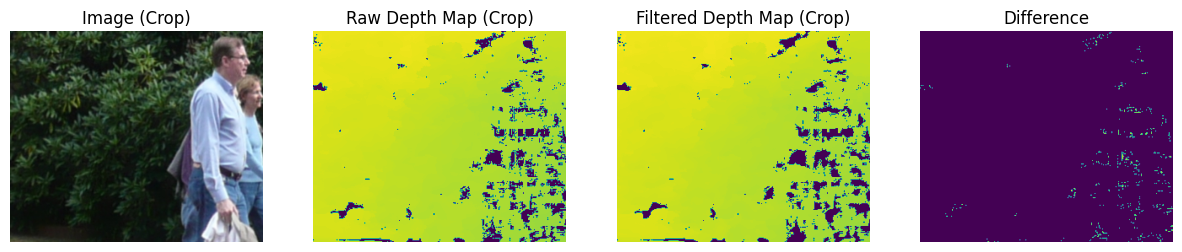

In [5]:
image = Image.open(os.path.join(dense_model_dir, "images", image_fn)).convert("RGB")
depth_map_0 = load_depth_map(os.path.join(dense_model_dir, "stereo", "depth_maps", f"{image_fn}.geometric.bin"))
depth_map_1 = filter_unstable_depths(depth_map_0)

plot_images([image, depth_map_0, depth_map_1, depth_map_0 - depth_map_1], ["Image", "Raw Depth Map", "Filtered Depth Map", "Difference"])
crop = np.s_[-250:,-1300:-1000]
plot_images([np.array(image)[crop], depth_map_0[crop], depth_map_1[crop], depth_map_0[crop] - depth_map_1[crop]], ["Image (Crop)", "Raw Depth Map (Crop)", "Filtered Depth Map (Crop)", "Difference"])

### Semantic Segmentation
Next, we extract a segmentation map from the image.

Loading weights for net_encoder
Loading weights for net_decoder


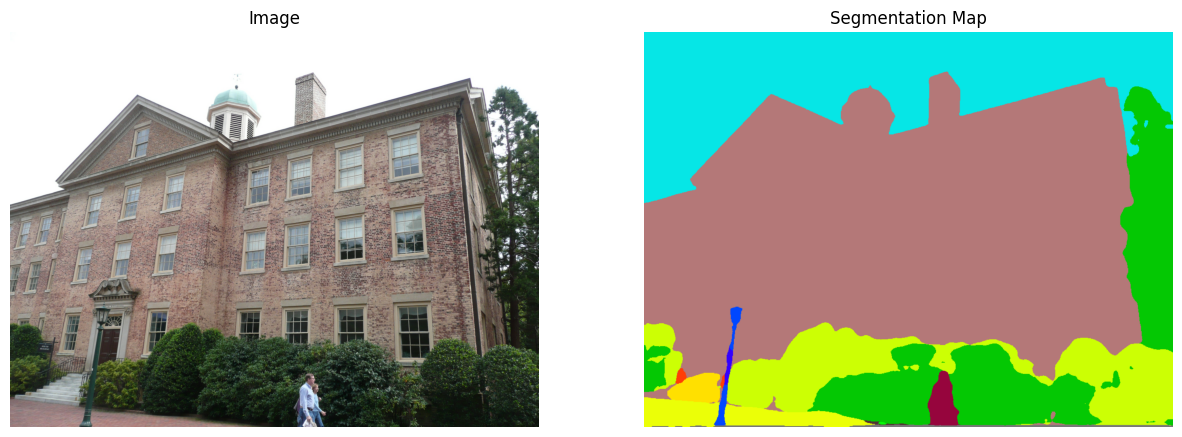

In [6]:
model = get_segmentation_model()
segmentation_map = get_segmentation_map(image, model)

plot_images([image, colorEncode(segmentation_map, colors)], ["Image", "Segmentation Map"])

### Semantic Filtering

Using the segmentation map, we can extract different types of masks. Below are some examples.

*Note: Our label IDs are 0-indexed (just like in the segmentation maps) while the label IDs in the [ADE20K Google Sheets](https://docs.google.com/spreadsheets/d/1se8YEtb2detS7OuPE86fXGyD269pMycAWe2mtKUj2W8/edit?usp=sharing) are 1-indexed.* 

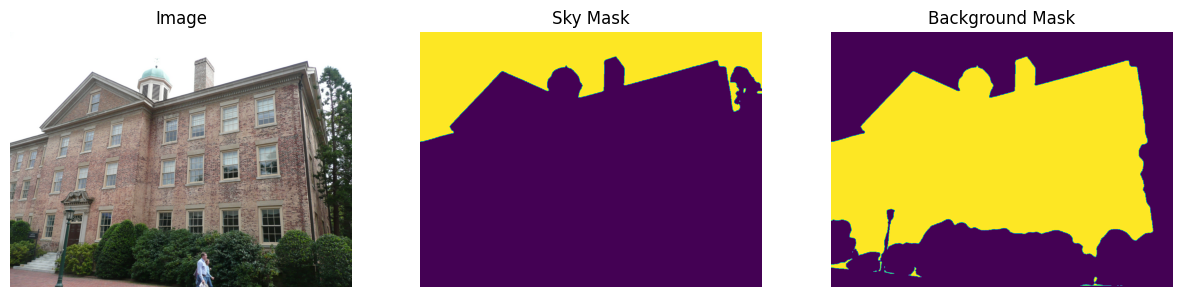

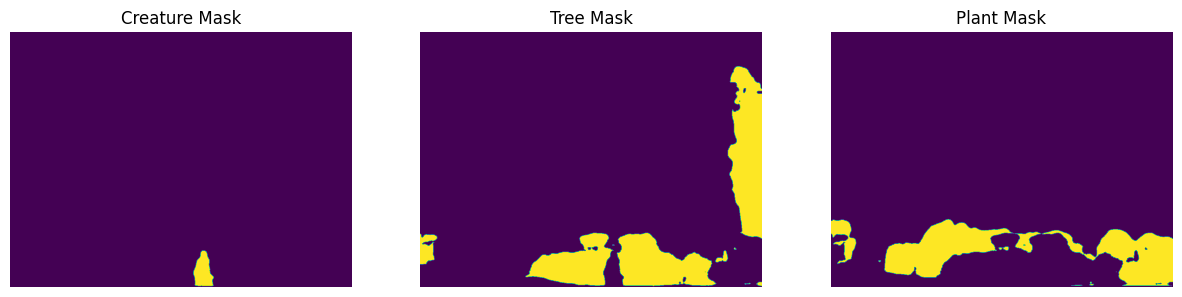

In [7]:
sky_mask = get_mask(segmentation_map, "sky")
background_mask = get_mask(segmentation_map, "background")
creature_mask = get_mask(segmentation_map, "creature")
tree_mask = get_mask(segmentation_map, "tree")
plant_mask = get_mask(segmentation_map, "plant")

plot_images([image, sky_mask, background_mask], ["Image", "Sky Mask", "Background Mask"])
plot_images([creature_mask, tree_mask, plant_mask], ["Creature Mask", "Tree Mask", "Plant Mask"])

Using the different masks, we can apply semantic filtering. For that, we set the depth values in each connected component of certain foreground masks to 0 if the fraction of valid depth values in the component is too small. Moreover, we remove all depth values from the sky region as well as from certain foreground classes.

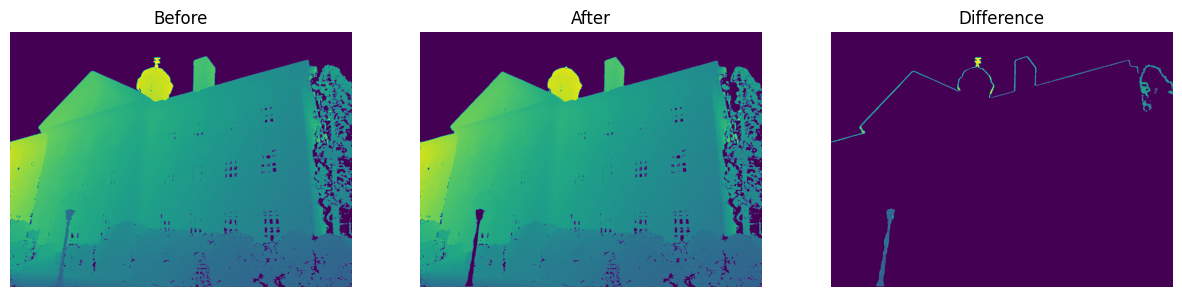

In [8]:
depth_map_2 = apply_semantic_filtering(depth_map_1, segmentation_map)
plot_images([depth_map_1, depth_map_2, depth_map_1 - depth_map_2], ["Before", "After", "Difference"])

### Image Processing II
Finally, we apply morphological erosion and remove small connected components.

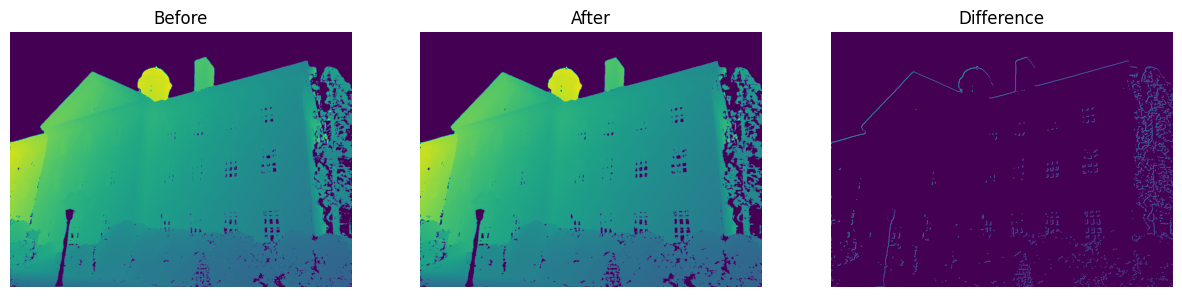

In [9]:
depth_map_3 = erode_and_remove(depth_map_2)
plot_images([depth_map_2, depth_map_3, depth_map_2 - depth_map_3], ["Before", "After", "Difference"])